# Code for Final Project
COGS 118A: Intro to Supervised Machine Learning  
Andrew Washington

### Generally Useful Code

In [7]:
# Helpful functions

# Split full dataset into test set and training set
def splitTestTrain(r, X, Y):
    Xtrain = X[:int(r*len(X))]
    Ytrain = Y[:int(r*len(X))]
    Xtest = X[int(r*len(X))+1 : len(X)]
    Ytest = Y[int(r*len(X))+1 : len(X)]
    return Xtrain, Ytrain, Xtest, Ytest

# Do cross-validation (w/ no shuffling)
def crossvalidate(classifier, folds, X, Y, verbose=False):
    foldSize = int(len(X)/folds)
    error = np.zeros(folds)
    for i in range(folds):
        start = i*foldSize
        end = start + foldSize
        if(end > len(X) - foldSize):
            end = len(X) - foldSize
        if(start >= end):
            continue
        
        Xtrain = np.concatenate((X[:start], X[end:-1]))
        Ytrain = np.concatenate((Y[:start], Y[end:-1]))
        
        classifier.fit(Xtrain, Ytrain)

        # Calculate training error
        numCorrect = 0
        numWrong = 0
        for j in range(len(X[start:end])):
            if(classifier.predict(X[j].reshape(1, -1)) == Y[j]):
                numCorrect = numCorrect + 1
            else:
                numWrong = numWrong + 1
        error[i] = numWrong / (numCorrect + numWrong)
        
        if(verbose == True):
            print('Fold #' + str(i))
            print('Fold size: ' + str(end - start))
            print('Error: ' + str(error[i]))
    return np.mean(error), np.var(error)

# Compute accuracy, returns % of test set predicted incorrectly
def testError(classifier, Xtest, Ytest):
    numCorrect = 0
    numWrong = 0
    for i in range(len(Xtest)):
        if(classifier.predict(Xtest[i].reshape(1, -1)) == Ytest[i]):
            numCorrect = numCorrect + 1
        else:
            numWrong = numWrong + 1
    return numWrong / (numCorrect + numWrong)

### Data

In [5]:
import numpy as np
import pandas as pd
import scipy.io as spio
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
%load_ext memory_profiler
import time

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### Encode Adult dataset using one hot encoding

In [2]:
# Load adult data
pdadult = pd.read_csv('data/adult.csv', header=-1)
adult = pdadult.as_matrix()

adultX = np.zeros((len(adult), 41))

# age
adultX[:,0] = adult[:,0]

# Encode employment using 1 hot encoding scheme
for i in range(len(adult[:,1])):
    if(adult[i,1] == ' Private'):
        adultX[i, 1] = 1
    elif(adult[i,1] == ' Self-emp-not-inc'):
        adultX[i,2] = 1
    elif(adult[i,1] == ' Local-gov'):
        adultX[i, 3] = 1
    elif(adult[i,1] == ' State-gov'):
        adultX[i, 5] = 1
    elif(adult[i,1] == ' Self-emp-inc'):
        adultX[i, 6] = 1
    elif(adult[i,1] == ' Federal-gov'):
        adultX[i, 7] = 1
    elif(adult[i,1] == ' Without-pay'):
        adultX[i, 8] = 1
    elif(adult[i,1] == ' Never-worked'):
        adultX[i, 9] = 1
    else:
        adultX[i, 4] = 1 # includes ' ?'
        
# continuous 
adultX[:,10] = adult[:,2]

# skip column 3, it's the same as the previous

# continuous
adultX[:,11] = adult[:,4]

# one hot encoding for marital status
for i in range(len(adult[:,5])):
    if(adult[i,5] == ' Married-civ-spouse'):
        adultX[i, 12] = 1
    elif(adult[i,5] == ' Never-married'):
        adultX[i,13] = 1
    elif(adult[i,5] == ' Divorced'):
        adultX[i, 14] = 1
    elif(adult[i,5] == ' Separated'):
        adultX[i, 15] = 1
    elif(adult[i,5] == ' Widowed'):
        adultX[i, 16] = 1
    elif(adult[i,5] == ' Married-spouse-absent'):
        adultX[i, 17] = 1
    elif(adult[i,5] == ' Married-AF-spouse'):
        adultX[i, 18] = 1

# one hot encoding for occupation
for i in range(len(adult[:,6])):
    if(adult[i,6] == ' Prof-specialty'):
        adultX[i, 19] = 1
    elif(adult[i,6] == ' Craft-repair'):
        adultX[i,20] = 1
    elif(adult[i,6] == ' Exec-managerial'):
        adultX[i, 21] = 1
    elif(adult[i,6] == ' Adm-clerical'):
        adultX[i, 22] = 1
    elif(adult[i,6] == ' Sales'):
        adultX[i, 23] = 1
    elif(adult[i,6] == ' Other-service'):
        adultX[i, 24] = 1
    elif(adult[i,6] == ' Machine-op-inspct'):
        adultX[i, 25] = 1
    elif(adult[i,6] == ' Transport-moving'):
        adultX[i,26] = 1
    elif(adult[i,6] == ' Handlers-cleaners'):
        adultX[i, 27] = 1
    elif(adult[i,6] == ' Farming-fishing'):
        adultX[i, 28] = 1
    elif(adult[i,6] == ' Tech-support'):
        adultX[i, 29] = 1
    elif(adult[i,6] == ' Protective-serv' or adult[i,6] == 'Priv-house-serv'):
        adultX[i, 30] = 1
    else:
        adultX[i, 31] = 1

# drop 7, correlated heavily to 5

# one hot encoding for ethnicity
for i in range(len(adult[:,8])):
    if(adult[i,8] == ' White'):
        adultX[i, 32] = 1
    elif(adult[i,8] == ' Black'):
        adultX[i,33] = 1
    elif(adult[i,8] == ' Asian-Pac-Islander'):
        adultX[i, 34] = 1
    else:
        adultX[i, 35] = 1

# one hot encoding for gender
for i in range(len(adult[:,9])):
    if(adult[i,9] == ' Male'):
        adultX[i, 36] = 1
    else:
        adultX[i, 37] = 1

# continuous
adultX[:,38] = adult[:,10]

# continuous
adultX[:,39] = adult[:,11]

# continuous
adultX[:,40] = adult[:,12]

# drop 13, heavily weighted towards United States

adultY = adult[:,14]

print(adultX.shape)
print(adultY.shape)

(32561, 41)
(32561,)


In [3]:
# Load ionosphere data
ionosphere = spio.loadmat('data/ionosphere.mat')
ionX = ionosphere['X']
ionYchar = ionosphere['Y']
ionY = np.zeros(len(ionYchar))

# Convert labels from {b,g} to {0,1}
for i in range(len(ionYchar)):
    if(ionYchar[i] == 'b'):
        ionY[i] = 0
    elif(ionYchar[i] == 'g'):
        ionY[i] = 1
    else:
        ionY[i] == -1

In [4]:
# Load arrhythmia data
arrhythmia = spio.loadmat('data/arrhythmia.mat')
arrX = arrhythmia['X']
arrY = arrhythmia['Y']

# Convert descriptive labels into binary labels, like done in assignment 5
for i in range(len(arrY)):
    if(arrY[i] != 1):
        arrY[i] = 0
        
arrX[np.isnan(arrX)] = 0
arrY = np.ravel(arrY)
arrX.shape

(452, 279)

### Methods

In [8]:
# Example of timing
%timeit for i in range(10): x = np.sqrt(np.pi);

100000 loops, best of 3: 11.7 µs per loop


In [9]:
# Example of timing
%timeit for i in range(1000): x = np.sqrt(np.pi);

1000 loops, best of 3: 1.06 ms per loop


In [79]:
# Example of memory
%memit
z = np.ones(10)

peak memory: 210.41 MiB, increment: 0.00 MiB


In [11]:
# Example of memory
old_mem = %memit -o x = 1;
curr_mem = %memit -o a = np.linspace(-4,100000,10000000);
mem_used = curr_mem.mem_usage[0] - old_mem.mem_usage[0]
print('Memory used in the previous line: ' + str(mem_used) + ' MiB')

peak memory: 118.41 MiB, increment: 0.01 MiB
peak memory: 347.30 MiB, increment: 228.89 MiB
Memory used in the previous line: 228.890625 MiB


## Results

### KNN, Adult: ball_tree

In [100]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, adultX, adultY)

In [101]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 216 ms, sys: 2.3 ms, total: 218 ms
Wall time: 218 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [102]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 3.35 s, sys: 17.4 ms, total: 3.37 s
Wall time: 3.37 s
Accuracy: 0.73388
Number of predictions: 6512


In [103]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 230 ms, sys: 4.35 ms, total: 235 ms
Wall time: 237 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [104]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 3.66 s, sys: 16.9 ms, total: 3.67 s
Wall time: 3.68 s
Accuracy: 0.75599
Number of predictions: 6512


In [105]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 246 ms, sys: 3.52 ms, total: 250 ms
Wall time: 250 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [106]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 3.71 s, sys: 16.7 ms, total: 3.73 s
Wall time: 3.74 s
Accuracy: 0.77196
Number of predictions: 6512


In [107]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 206 ms, sys: 2.56 ms, total: 209 ms
Wall time: 208 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [108]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 3.58 s, sys: 14.8 ms, total: 3.59 s
Wall time: 3.6 s
Accuracy: 0.77979
Number of predictions: 6512


### KNN, Adult: kd tree

In [109]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 207 ms, sys: 2.63 ms, total: 209 ms
Wall time: 208 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [110]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 2.79 s, sys: 13.2 ms, total: 2.8 s
Wall time: 2.81 s
Accuracy: 0.73388
Number of predictions: 6512


In [111]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 231 ms, sys: 4.6 ms, total: 235 ms
Wall time: 233 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [112]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 3.05 s, sys: 15.7 ms, total: 3.07 s
Wall time: 3.08 s
Accuracy: 0.75599
Number of predictions: 6512


In [113]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 225 ms, sys: 3.16 ms, total: 228 ms
Wall time: 228 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [114]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 2.9 s, sys: 12.8 ms, total: 2.92 s
Wall time: 2.92 s
Accuracy: 0.77196
Number of predictions: 6512


In [115]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 215 ms, sys: 3.44 ms, total: 219 ms
Wall time: 218 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [116]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 2.89 s, sys: 12 ms, total: 2.9 s
Wall time: 2.91 s
Accuracy: 0.77994
Number of predictions: 6512


### KNN, Adult: brute

In [117]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 23.8 ms, sys: 1.3 ms, total: 25.1 ms
Wall time: 23.4 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [118]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 23.5 s, sys: 646 ms, total: 24.1 s
Wall time: 20.9 s
Accuracy: 0.73372
Number of predictions: 6512


In [119]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 28.7 ms, sys: 3.92 ms, total: 32.7 ms
Wall time: 29.4 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [120]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 22.8 s, sys: 697 ms, total: 23.4 s
Wall time: 20.4 s
Accuracy: 0.75599
Number of predictions: 6512


In [121]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 39.4 ms, sys: 2.36 ms, total: 41.8 ms
Wall time: 47.7 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [122]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 20.5 s, sys: 553 ms, total: 21.1 s
Wall time: 18.3 s
Accuracy: 0.77211
Number of predictions: 6512


In [123]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 27.6 ms, sys: 1.9 ms, total: 29.5 ms
Wall time: 31.4 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [124]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 20.8 s, sys: 573 ms, total: 21.3 s
Wall time: 18.5 s
Accuracy: 0.77979
Number of predictions: 6512


### KNN, Ionospere: ball tree

In [125]:
# Separate data into training and testing sets
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, ionX, ionY)

In [126]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.17 ms, sys: 586 µs, total: 1.76 ms
Wall time: 1.15 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [127]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 45.4 ms, sys: 2.12 ms, total: 47.5 ms
Wall time: 48.4 ms
Accuracy: 0.97143
Number of predictions: 70


In [128]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.26 ms, sys: 470 µs, total: 1.73 ms
Wall time: 1.39 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [129]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 36.3 ms, sys: 1.5 ms, total: 37.8 ms
Wall time: 37.1 ms
Accuracy: 0.97143
Number of predictions: 70


In [130]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.76 ms, sys: 668 µs, total: 2.42 ms
Wall time: 2.07 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [131]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 38.2 ms, sys: 1.82 ms, total: 40 ms
Wall time: 39.5 ms
Accuracy: 0.97143
Number of predictions: 70


In [132]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.2 ms, sys: 510 µs, total: 1.71 ms
Wall time: 1.17 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [133]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 39.1 ms, sys: 1.76 ms, total: 40.8 ms
Wall time: 40.3 ms
Accuracy: 0.97143
Number of predictions: 70


### KNN, Ionosphere: kd tree

In [134]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.12 ms, sys: 611 µs, total: 1.73 ms
Wall time: 1.1 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [135]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 36.3 ms, sys: 2.02 ms, total: 38.3 ms
Wall time: 37.3 ms
Accuracy: 0.97143
Number of predictions: 70


In [136]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.22 ms, sys: 422 µs, total: 1.64 ms
Wall time: 1.26 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [137]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 40.7 ms, sys: 2.03 ms, total: 42.7 ms
Wall time: 42 ms
Accuracy: 0.97143
Number of predictions: 70


In [138]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.15 ms, sys: 594 µs, total: 1.74 ms
Wall time: 1.14 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [139]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 38.6 ms, sys: 1.77 ms, total: 40.4 ms
Wall time: 39.7 ms
Accuracy: 0.97143
Number of predictions: 70


In [140]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.34 ms, sys: 605 µs, total: 1.95 ms
Wall time: 1.46 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [141]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 40.2 ms, sys: 2.22 ms, total: 42.5 ms
Wall time: 41.8 ms
Accuracy: 0.97143
Number of predictions: 70


### KNN, Ionosphere: brute

In [142]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.22 ms, sys: 557 µs, total: 1.78 ms
Wall time: 1.42 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [143]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 30.9 ms, sys: 1.88 ms, total: 32.8 ms
Wall time: 33 ms
Accuracy: 0.97143
Number of predictions: 70


In [144]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.26 ms, sys: 729 µs, total: 1.99 ms
Wall time: 1.39 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [145]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 28.9 ms, sys: 2.41 ms, total: 31.3 ms
Wall time: 29.7 ms
Accuracy: 0.97143
Number of predictions: 70


In [146]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 939 µs, sys: 459 µs, total: 1.4 ms
Wall time: 1.1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [147]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 28.2 ms, sys: 1.9 ms, total: 30.1 ms
Wall time: 29 ms
Accuracy: 0.97143
Number of predictions: 70


In [148]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 741 µs, sys: 260 µs, total: 1 ms
Wall time: 768 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [149]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 26.4 ms, sys: 2.02 ms, total: 28.4 ms
Wall time: 27.2 ms
Accuracy: 0.97143
Number of predictions: 70


### KNN, Arrhythmia: ball tree

In [150]:
# Separate data into training and testing sets
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, arrX, arrY)

In [151]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.84 ms, sys: 1.6 ms, total: 5.44 ms
Wall time: 4.14 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [152]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 63.5 ms, sys: 2.19 ms, total: 65.7 ms
Wall time: 65.7 ms
Accuracy: 0.71111
Number of predictions: 90


In [153]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 4.32 ms, sys: 1.84 ms, total: 6.16 ms
Wall time: 4.65 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [154]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 63.6 ms, sys: 2.06 ms, total: 65.7 ms
Wall time: 66 ms
Accuracy: 0.8
Number of predictions: 90


In [155]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.97 ms, sys: 1.6 ms, total: 5.57 ms
Wall time: 4.36 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [156]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 82.9 ms, sys: 2.78 ms, total: 85.7 ms
Wall time: 91.8 ms
Accuracy: 0.75556
Number of predictions: 90


In [157]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.67 ms, sys: 1.6 ms, total: 5.27 ms
Wall time: 3.81 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [158]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 67.2 ms, sys: 2.21 ms, total: 69.4 ms
Wall time: 69.4 ms
Accuracy: 0.71111
Number of predictions: 90


### KNN, Arrhythmia: kd tree

In [159]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 4.61 ms, sys: 2.22 ms, total: 6.83 ms
Wall time: 5.78 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [160]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 68.8 ms, sys: 2.26 ms, total: 71 ms
Wall time: 70.6 ms
Accuracy: 0.71111
Number of predictions: 90


In [161]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.51 ms, sys: 1.79 ms, total: 5.3 ms
Wall time: 3.65 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [162]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 71.6 ms, sys: 2.05 ms, total: 73.6 ms
Wall time: 74 ms
Accuracy: 0.8
Number of predictions: 90


In [163]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.55 ms, sys: 1.66 ms, total: 5.21 ms
Wall time: 4.04 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [164]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 69.4 ms, sys: 2.44 ms, total: 71.8 ms
Wall time: 71.5 ms
Accuracy: 0.75556
Number of predictions: 90


In [165]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 3.53 ms, sys: 1.67 ms, total: 5.2 ms
Wall time: 3.85 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [166]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 71.4 ms, sys: 1.78 ms, total: 73.2 ms
Wall time: 73.4 ms
Accuracy: 0.71111
Number of predictions: 90


### KNN, Arrhythmia: brute

In [167]:
neigh = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 2.22 ms, sys: 724 µs, total: 2.95 ms
Wall time: 2.29 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [168]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 94.3 ms, sys: 7.6 ms, total: 102 ms
Wall time: 97.6 ms
Accuracy: 0.71111
Number of predictions: 90


In [169]:
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.33 ms, sys: 600 µs, total: 1.93 ms
Wall time: 1.3 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [170]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 89.4 ms, sys: 6.99 ms, total: 96.4 ms
Wall time: 92.1 ms
Accuracy: 0.8
Number of predictions: 90


In [171]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.44 ms, sys: 645 µs, total: 2.09 ms
Wall time: 1.36 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [172]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 92.3 ms, sys: 7.25 ms, total: 99.5 ms
Wall time: 96 ms
Accuracy: 0.75556
Number of predictions: 90


In [173]:
neigh = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
%time neigh.fit(Xtrain, Ytrain)

CPU times: user 1.41 ms, sys: 800 µs, total: 2.21 ms
Wall time: 1.28 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [174]:
%time err = testError(neigh, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 90.9 ms, sys: 6.74 ms, total: 97.7 ms
Wall time: 93.5 ms
Accuracy: 0.71111
Number of predictions: 90


### Random Forest, Adult Tuning

In [41]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, adultX, adultY)

Optimal max depth: 12


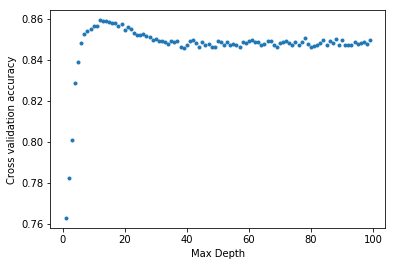

In [42]:
depths = np.arange(1,100)
cvmeans = np.zeros(len(depths))
times = np.zeros(len(depths))
for d in range(1, 1+len(cvmeans)):
    start = time.time()
    rf = RandomForestClassifier(max_depth=d)
    cvmeans[d-1] = cross_val_score(rf, Xtrain, Ytrain, cv=5).mean()
    times[d-1] = time.time() - start
plt.xlabel('Max Depth')
plt.ylabel('Cross validation accuracy')
plt.plot(depths, cvmeans,'.')
print('Optimal max depth: ' + str(depths[np.argmax(cvmeans)]))

Total Time (for all CV): 124.590257406


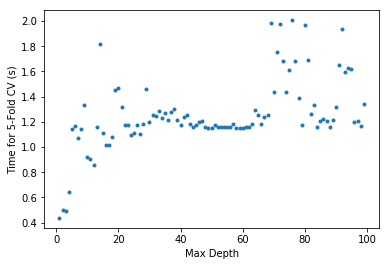

In [43]:
plt.xlabel('Max Depth')
plt.ylabel('Time for 5-Fold CV (s)')
plt.plot(depths, times, '.')
print('Total Time (for all CV): ' + str(np.sum(times)))

### Random Forest, Adult Timing

In [191]:
rf = RandomForestClassifier(max_depth=depths[np.argmax(cvmeans)])
%time rf.fit(Xtrain, Ytrain)

CPU times: user 269 ms, sys: 7.66 ms, total: 277 ms
Wall time: 281 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [192]:
%time err = testError(rf, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 7.18 s, sys: 88.7 ms, total: 7.27 s
Wall time: 7.44 s
Accuracy: 0.85857
Number of predictions: 6512


### Random Forest, Ionosphere Tuning

In [29]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, ionX, ionY)

Optimal max depth: 39


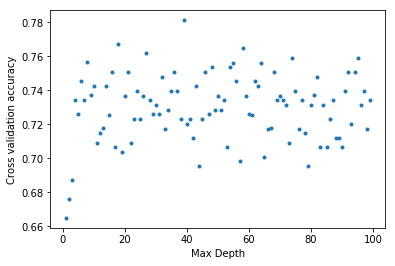

In [39]:
depths = np.arange(1,100)
cvmeans = np.zeros(len(depths))
times = np.zeros(len(depths))
for d in range(1, 1+len(cvmeans)):
    start = time.time()
    rf = RandomForestClassifier(max_depth=d)
    cvmeans[d-1] = cross_val_score(rf, Xtrain, Ytrain, cv=5).mean()
    times[d-1] = time.time() - start
plt.xlabel('Max Depth')
plt.ylabel('Cross validation accuracy')
plt.plot(depths, cvmeans,'.')
print('Optimal max depth: ' + str(depths[np.argmax(cvmeans)]))

Total Time (for all CV): 10.9833440781


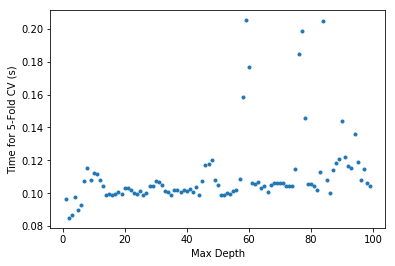

In [40]:
plt.xlabel('Max Depth')
plt.ylabel('Time for 5-Fold CV (s)')
plt.plot(depths, times, '.')
print('Total Time (for all CV): ' + str(np.sum(times)))

### Random Forest, Ionosphere Timing

In [47]:
rf = RandomForestClassifier(max_depth=depths[np.argmax(cvmeans)])
%time rf.fit(Xtrain, Ytrain)

CPU times: user 25.1 ms, sys: 1.28 ms, total: 26.4 ms
Wall time: 25.1 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=93, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [48]:
%time err = testError(rf, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 100 ms, sys: 3.04 ms, total: 103 ms
Wall time: 103 ms
Accuracy: 0.78889
Number of predictions: 90


### Random Forest, Arrhythmia Tuning

In [44]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, arrX, arrY)

Optimal max depth: 93


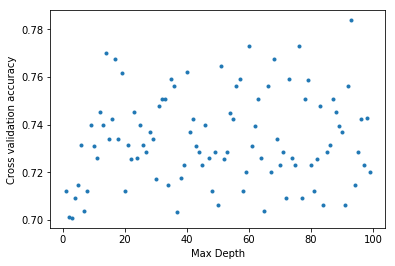

In [45]:
depths = np.arange(1,100)
cvmeans = np.zeros(len(depths))
times = np.zeros(len(depths))
for d in range(1, 1+len(cvmeans)):
    start = time.time()
    rf = RandomForestClassifier(max_depth=d)
    cvmeans[d-1] = cross_val_score(rf, Xtrain, Ytrain, cv=5).mean()
    times[d-1] = time.time() - start
plt.xlabel('Max Depth')
plt.ylabel('Cross validation accuracy')
plt.plot(depths, cvmeans,'.')
print('Optimal max depth: ' + str(depths[np.argmax(cvmeans)]))

Total Time (for all CV): 13.0419499874


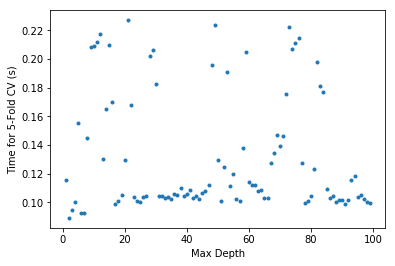

In [46]:
plt.xlabel('Max Depth')
plt.ylabel('Time for 5-Fold CV (s)')
plt.plot(depths, times, '.')
print('Total Time (for all CV): ' + str(np.sum(times)))

### Random Forest, Arrhythmia Timing

In [37]:
rf = RandomForestClassifier(max_depth=depths[np.argmax(cvmeans)])
%time rf.fit(Xtrain, Ytrain)

CPU times: user 23.2 ms, sys: 1.24 ms, total: 24.5 ms
Wall time: 23.2 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [38]:
%time err = testError(rf, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 101 ms, sys: 3.13 ms, total: 104 ms
Wall time: 104 ms
Accuracy: 0.72222
Number of predictions: 90


### AdaBoost, Adult Tuning

In [8]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, adultX, adultY)

Optimal number of estimators: 98


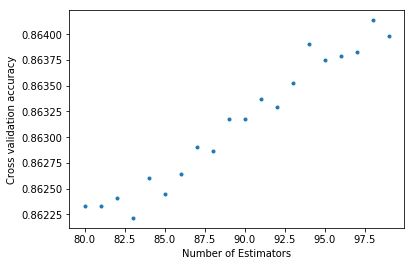

In [96]:
# tested from 1 to 100, 98 is best
est = np.arange(80,100)
cvmeans = np.zeros(len(est))
times = np.zeros(len(est))
for e in range(1, 1+len(cvmeans)):
    start= time.time()
    ada = AdaBoostClassifier(n_estimators=est[e-1])
    cvmeans[e-1] = cross_val_score(ada, Xtrain, Ytrain, cv=5).mean()
    times[e-1] = time.time() - start
plt.xlabel('Number of Estimators')
plt.ylabel('Cross validation accuracy')
plt.plot(est, cvmeans,'.')
print('Optimal number of estimators: ' + str(est[np.argmax(cvmeans)]))

In [ ]:
plt.xlabel('Max Depth')
plt.ylabel('Time for 5-Fold CV (s)')
plt.plot(depths, times, '.')
print('Total Time (for all CV): ' + str(np.sum(times)))

### Adaboost, Adult Timing

In [9]:
ada = AdaBoostClassifier(n_estimators = 98)
%time ada.fit(Xtrain, Ytrain)

CPU times: user 4.79 s, sys: 43 ms, total: 4.83 s
Wall time: 4.9 s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=98, random_state=None)

In [10]:
%time err = testError(ada, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 41.9 s, sys: 391 ms, total: 42.3 s
Wall time: 41.7 s
Accuracy: 0.86886
Number of predictions: 6512


### AdaBoost, Ionosphere Tuning

In [11]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, ionX, ionY)

Optimal number of estimators: 13


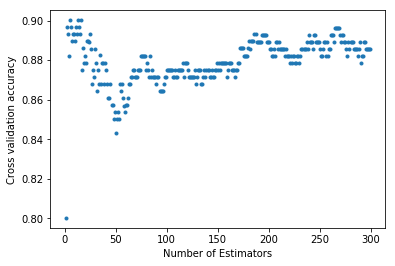

In [225]:
est = np.arange(1,300)
cvmeans = np.zeros(len(est))
for e in range(1, 1+len(cvmeans)):
    ada = AdaBoostClassifier(n_estimators=est[e-1])
    cvmeans[e - 1] = cross_val_score(ada, Xtrain, Ytrain, cv=5).mean()
plt.xlabel('Number of Estimators')
plt.ylabel('Cross validation accuracy')
plt.plot(est, cvmeans,'.')
print('Optimal number of estimators: ' + str(est[np.argmax(cvmeans)]))

### Adaboost, Ionosphere Timing

In [12]:
ada = AdaBoostClassifier(n_estimators = 13)
%time ada.fit(Xtrain, Ytrain)

CPU times: user 43.8 ms, sys: 1.45 ms, total: 45.3 ms
Wall time: 46.1 ms


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=13, random_state=None)

In [13]:
%time err = testError(ada, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 83.4 ms, sys: 3.78 ms, total: 87.2 ms
Wall time: 86.2 ms
Accuracy: 0.94286
Number of predictions: 70


### AdaBoost, Arrhythmia Tuning

In [14]:
Xtrain, Ytrain, Xtest, Ytest = splitTestTrain(0.8, arrX, arrY)

In [229]:
# up to 285 tested, 76 seems to be the winner
# error shows because it was interrupted at e=286
est = np.arange(1,300)
cvmeans = np.zeros(len(est))
for e in range(1, 1+len(cvmeans)):
    ada = AdaBoostClassifier(n_estimators=est[e-1])
    cvmeans[e - 1] = cross_val_score(ada, Xtrain, Ytrain, cv=5).mean()
plt.xlabel('Number of Estimators')
plt.ylabel('Cross validation accuracy')
plt.plot(est, cvmeans,'.')
print('Optimal number of estimators: ' + str(est[np.argmax(cvmeans)]))

KeyboardInterrupt: 

### Adaboost, Arrhythmia Timing

In [15]:
ada = AdaBoostClassifier(n_estimators = 76)
%time ada.fit(Xtrain, Ytrain)

CPU times: user 290 ms, sys: 2.45 ms, total: 292 ms
Wall time: 293 ms


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=76, random_state=None)

In [16]:
%time err = testError(ada, Xtest, Ytest)
print('Accuracy: {:.5}'.format(1-err))
print('Number of predictions: ' + str(len(Ytest)))

CPU times: user 432 ms, sys: 5.28 ms, total: 437 ms
Wall time: 437 ms
Accuracy: 0.75556
Number of predictions: 90


### Extra Code

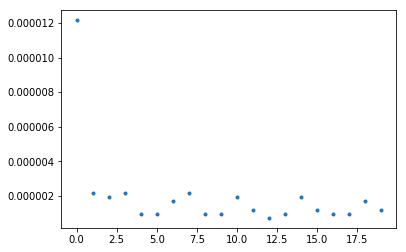

In [21]:
times = np.zeros(20)
for i in range(20):
    start = time.time()
    x = np.sqrt(np.pi**5)
    end = time.time()
    times[i] = end - start
plt.plot(times, '.')

In [19]:
time.time()

1497734126.042486